In [105]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import textwrap
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
import seaborn as sns
from matplotlib import pyplot
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import math

#parameters for selecting data: type in the start date, the latest available date in the data is the end date
param_start_date='11/08/2016'

In [106]:
#read tweets and stock market data
name_tweets = "tweet_stock_results.json"

with open(name_tweets, "r") as file:
    tweets_df = pd.read_json(file, orient='index')
print(tweets_df.columns)

tweets_df.sort_index(inplace=True)
tweets_df = tweets_df.reset_index(drop=True)
#tweets_df=tweets_df1.loc[tweets_df1.index<=14]
print("Number of tweets: ", len(tweets_df))

#select the data sets based on the param_start_date
tweets_df=tweets_df.loc[tweets_df["timestamp"] > datetime.strptime(param_start_date, '%m/%d/%Y')]
print("Number of tweets after the start date: ", len(tweets_df))

Index(['daily change', 'date', 'difference', 'orig changes', 'orig stock',
       'predicted changes', 'prev stock', 'text', 'timestamp', 'tweet'],
      dtype='object')
Number of tweets:  5762
Number of tweets after the start date:  980


In [107]:
#partition of the data in six classes
tweets_dfbp=tweets_df.loc[tweets_df["orig changes"]=='BIGPOS']
print(len(tweets_dfbp))
tweets_dfbn=tweets_df.loc[tweets_df["orig changes"]=='BIGNEG']
print(len(tweets_dfbn))
tweets_dfmp=tweets_df.loc[tweets_df["orig changes"]=='MEDPOS']
print(len(tweets_dfmp))
tweets_dfmn=tweets_df.loc[tweets_df["orig changes"]=='MEDNEG']
print(len(tweets_dfmn))
tweets_dfsp=tweets_df.loc[tweets_df["orig changes"]=='SMAPOS']
print(len(tweets_dfsp))
tweets_dfsn=tweets_df.loc[tweets_df["orig changes"]=='SMANEG']
print(len(tweets_dfsn))

132
63
259
189
94
117


In [108]:
def most_common(data,number):
    most_common = Counter(" ".join(data["text"].dropna()).split()).most_common(number)
    print("Most common words: ", most_common)


def aggregate_tfidf(data,number):
    # Ignore too common terms (max_df = .25)
    v_data = TfidfVectorizer(max_df = .25)
    X_data = v_data.fit_transform(data["text"])

    X_mean= X_data.mean(axis=0)
    vec =[]
    for i in range(len(data)):
        vec.append(X_mean.item(i))

    data['tf_idf']=pd.Series(vec, index=data.index)
    #print(data.head())
    
    highest = [v_data.get_feature_names()[id] for id in (-X_data.mean(axis=0).A).argsort()[0][:number]]
    #print("Highest scores: ", highest)



In [109]:
#print most common x words
#most_common(tweets_dfbp,20)

#aggregate TF/IDF for sentence vector and print most common x words
aggregate_tfidf(tweets_dfbp,20)
aggregate_tfidf(tweets_dfbn,20)
aggregate_tfidf(tweets_dfmp,20)
aggregate_tfidf(tweets_dfmn,20)
aggregate_tfidf(tweets_dfsp,20)
aggregate_tfidf(tweets_dfsn,20)


C:\Users\Suvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [110]:
tweets_dfb=tweets_dfbp.append(tweets_dfbn)
print(len(tweets_dfb))
tweets_dfm=tweets_dfmp.append(tweets_dfmn)
print(len(tweets_dfm))
tweets_dfs=tweets_dfsp.append(tweets_dfsn)
print(len(tweets_dfs))
tweets_dfbm=tweets_dfb.append(tweets_dfm)
print(len(tweets_dfbm))
tweets_dfbms=tweets_dfbm.append(tweets_dfs)
print(len(tweets_dfbms))
tweets_dfbms.sort_index(inplace=True)
print(tweets_dfbms.head())

195
448
211
643
854
      daily change       date  difference orig changes  orig stock  \
4782      256.9493 2016-11-08         0.0       BIGPOS  18332.7402   
4783      256.9493 2016-11-08         1.0       BIGPOS  18332.7402   
4784      256.9493 2016-11-08         1.0       BIGPOS  18332.7402   
4785      256.9493 2016-11-08         1.0       BIGPOS  18332.7402   
4786      256.9493 2016-11-08         1.0       BIGPOS  18332.7402   

     predicted changes  prev stock  \
4782            MEDPOS  18259.5996   
4783            BIGPOS  18259.5996   
4784            BIGPOS  18259.5996   
4785            BIGPOS  18259.5996   
4786            BIGPOS  18259.5996   

                                                   text           timestamp  \
4782  rt https https in michigan this is your moveme... 2016-11-08 04:27:18   
4783  rt https thanks new hampshire nh newhampshire ... 2016-11-08 04:29:10   
4784                            electionday https https 2016-11-08 18:23:39   
4785  still ti

In [111]:
tweets_dfx=tweets_df.loc[tweets_df["orig changes"]!=tweets_df["predicted changes"]]
print("Predicted change is identical to the real stock market change",len(tweets_df)-len(tweets_dfx))
print("Predicted change is not identical to the real stock market change",len(tweets_dfx))


tweets_df1x=tweets_dfx.loc[(tweets_dfx["orig changes"].values=='BIGPOS') | (tweets_dfx["orig changes"].values=='MEDPOS') |
                         (tweets_dfx["orig changes"].values=='SMAPOS')]
tweets_df1=tweets_df1x.loc[(tweets_df1x["predicted changes"].values=='BIGPOS') | (tweets_df1x["predicted changes"].values=='MEDPOS') |
                         (tweets_df1x["predicted changes"].values=='SMAPOS')]


tweets_df2x=tweets_dfx.loc[(tweets_dfx["orig changes"].values=='BIGNEG') | (tweets_dfx["orig changes"].values=='MEDNEG') |
                         (tweets_dfx["orig changes"].values=='SMANEG')]
tweets_df2=tweets_df2x.loc[(tweets_df2x["predicted changes"].values=='BIGNEG') | (tweets_df2x["predicted changes"].values=='MEDNEG') |
                         (tweets_df2x["predicted changes"].values=='SMANEG')]

print("Predicted change is not equal but the direction is the same with the real stock market change",len(tweets_df1)+len(tweets_df2))

print("The direction of predicted change is opposite to the stock market change",len(tweets_dfx)-(len(tweets_df1)+len(tweets_df2)))


Predicted change is identical to the real stock market change 500
Predicted change is not identical to the real stock market change 480
Predicted change is not equal but the direction is the same with the real stock market change 132
The direction of predicted change is opposite to the stock market change 348


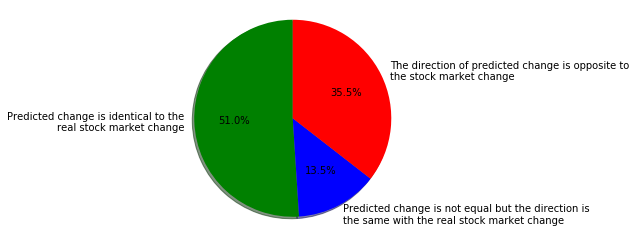

In [112]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
text1=textwrap.fill('Predicted change is identical to the real stock market change', width=40)
text2=textwrap.fill('Predicted change is not equal but the direction is the same with the real stock market change', width=50)
text3=textwrap.fill('The direction of predicted change is opposite to the stock market change', width=50)
labels = text1, text2, text3
colors  = ("green", "blue", "red")
sizes = [len(tweets_df)-len(tweets_dfx),len(tweets_df1)+len(tweets_df2),len(tweets_dfx)-(len(tweets_df1)+len(tweets_df2))]
#print(len(tweets_df),len(tweets_df1), len(tweets_df2))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [113]:
#descriptive statistics


#stats for stock market data in predicted and original classes - not very informative
grouped_data = tweets_df.groupby(['orig changes']) #try adding 'predicted changes'
grouped_data['orig stock'].apply(mode, axis=None).reset_index()
descr = grouped_data['orig stock'].aggregate([np.median, np.std, np.mean, np.min, np.max]).reset_index()
descr

,orig changes,median,std,mean,amin,amax
0,BIGNEG,24667.7793,1628.258815,24131.578094,20591.8594,26743.5000
1,BIGPOS,24174.8203,2247.158583,23545.534376,18332.7402,26405.7598
2,MEDNEG,22349.5898,2092.027032,22712.494199,18903.8203,26562.0508
3,MEDPOS,22557.5996,1849.943184,22673.089176,18868.1406,26656.9805
4,SMANEG,21414.3398,1856.154648,22003.693655,19826.7695,26214.5996
5,SMAPOS,22016.2402,2061.108044,22429.295313,18847.6602,26145.9902


In [114]:
#stats for TF/IDF-scores in predicted and original classes 
grouped_data = tweets_dfbms.groupby(['orig changes']) #try adding 'predicted changes'
grouped_data['tf_idf'].apply(mode, axis=None).reset_index()
descr = grouped_data['tf_idf'].aggregate([np.median, np.std, np.mean, np.min, np.max]).reset_index()
descr

,orig changes,median,std,mean,amin,amax
0,BIGNEG,0.004646,0.005218,0.007056,0.003572,0.027230
1,BIGPOS,0.002277,0.003595,0.003778,0.001749,0.021032
2,MEDNEG,0.001651,0.003174,0.002965,0.001164,0.021470
3,MEDPOS,0.001216,0.003067,0.002401,0.000923,0.022242
4,SMANEG,0.002542,0.004421,0.004398,0.001866,0.028865
5,SMAPOS,0.003019,0.004570,0.005035,0.002336,0.029328


In [116]:
#2 Way Cross table/frequency table for amounts of tweet distribution between original stock market change classes and 
#predicted classes
pd.crosstab(tweets_df['orig changes'],tweets_df['predicted changes'], margins=True)

predicted changes,BIGNEG,BIGPOS,MEDNEG,MEDPOS,SMANEG,SMAPOS,All
orig changes,,,,,,,
BIGNEG,16,8,13,16,5,5,63
BIGPOS,16,56,11,29,9,11,132
MEDNEG,11,21,104,34,11,8,189
MEDPOS,14,14,28,179,14,10,259
SMANEG,5,9,8,13,80,2,117
SMAPOS,2,7,10,8,2,65,94
All,64,115,174,279,121,101,854


In [117]:
#2 Way Cross table/frequency percentage table for amounts of tweet distribution between original stock market change classes and 
#predicted classes
pd.crosstab(tweets_df['orig changes'],tweets_df['predicted changes'], margins=True, normalize='index')\
        .round(4)*100

predicted changes,BIGNEG,BIGPOS,MEDNEG,MEDPOS,SMANEG,SMAPOS
orig changes,,,,,,
BIGNEG,25.40,12.70,20.63,25.40,7.94,7.94
BIGPOS,12.12,42.42,8.33,21.97,6.82,8.33
MEDNEG,5.82,11.11,55.03,17.99,5.82,4.23
MEDPOS,5.41,5.41,10.81,69.11,5.41,3.86
SMANEG,4.27,7.69,6.84,11.11,68.38,1.71
SMAPOS,2.13,7.45,10.64,8.51,2.13,69.15
All,7.49,13.47,20.37,32.67,14.17,11.83


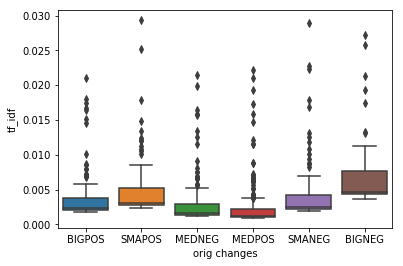

In [118]:
#distribution of TF/IDF scores within original stock market classes
sns.boxplot(x="orig changes", y="tf_idf", data=tweets_dfbms)

C:\Users\Suvi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


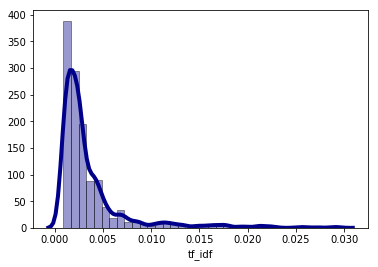

In [119]:
# Density Plot and Histogram of TF/IDF scores -not Gaussian
sns.distplot(tweets_dfbms['tf_idf'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

C:\Users\Suvi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


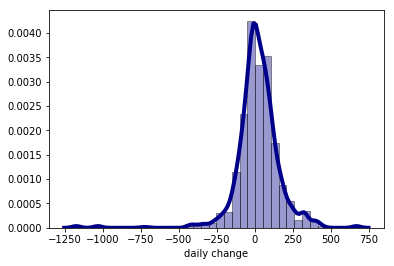

In [120]:
# Density Plot and Histogram of daily change -clearly Gaussian, normally distributed
sns.distplot(tweets_dfbms['daily change'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

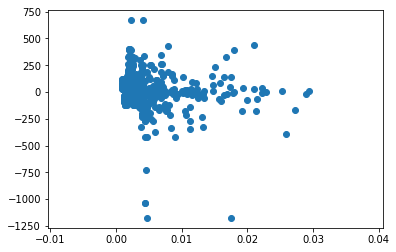

In [121]:
# plotting the data
pyplot.scatter(tweets_dfbms['tf_idf'],tweets_dfbms['daily change'])
pyplot.show()

In [122]:
#Chi-Square test of independency for two variables
#Spearman's and Kendall's Tau Correlation tests can be done also for non-normally distributed variables
#Pearson's correlation is reliable only for normally distributed variables
#if the p-value is much lower than 0.05, we reject the null hypothesis 
#and conclude that there is a statistically significant correlation

# calculate the correlation between two variables
def chisquare_result(data1, data2, alpha):
    coef1, p_value1 = spearmanr(data1, data2)
    coef2, p_value2 = kendalltau(data1, data2)
    coef3, p_value3 = pearsonr(data1, data2)
    test=[['Spearmans',coef1,p_value1], ['Kendalltau',coef2,p_value2], ['Pearsons',coef3,p_value3]]
    
    for value in test:
        print(value[0], 'correlation coefficient: %.3f' % value[1])

        # interpret the significance
        if math.fabs(value[2]) > alpha:
            print('Samples are uncorrelated (fail to reject H0) p=%.3f' % value[2])
        else:
            print('Samples are correlated (reject H0) p=%.3f' % value[2])
          

chisquare_result(tweets_dfbms['tf_idf'],tweets_dfbms['daily change'], 0.05)  


Spearmans correlation coefficient: -0.216
Samples are correlated (reject H0) p=0.000
Kendalltau correlation coefficient: -0.137
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: -0.149
Samples are correlated (reject H0) p=0.000
